# Convolutional Neural Nets

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/fitter-happier-models/blob/master/docs/notebooks/tensorflow/04-tensorflow-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/fitter-happier-models?style=social)](https://github.com/particle1331/fitter-happier-models)

---

## Introduction

Because pixels are spatially correlated, we want to incorporate this into the structure of our networks. In particular, we want to capture the characteristic **spatial locality** of features in images. A feature that is meaningful at a certain location should be equally meaningful for a model at another place in the image. Moreover, discriminative features typically exist only on localized regions in an image (e.g. a dog nose or cat ears), so that looking at large regions of the image can confuse the model. Some aspect of spatial locality is captured by **convolutional layers**. This naturally results in capacity reduction by allowing weight sharing between neurons.

**References:** {cite}`mlbook2022` {cite}`cams` {cite}`keras2` {cite}`dropout` [[Keras guides](https://keras.io/guides/transfer_learning/)]

In [1]:
import random
import warnings
from pathlib import Path

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib_inline import backend_inline

import tensorflow as tf
import tensorflow.keras as kr
from tensorflow.keras.datasets import cifar10


DATASET_DIR = Path("../input/").absolute()

warnings.simplefilter(action="once")
backend_inline.set_matplotlib_formats('svg')
matplotlib.rcParams["image.interpolation"] = "nearest"

seed = 43
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.6.4
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-11-24 21:01:47.632026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 21:01:47.713207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 21:01:47.714058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Convolution operation

In the the following example, the task is to classify an image whether it contains a cat or not using linear classification. Flattening the image into a vector is unstatisfying since we are discarding important spatial information (e.g. a network with a preprocessing layer that permutes the input neurons achieves the same result). Moreover, this results in too much capacity and takes too much memory and compute with a large number of pixels in the image that are not useful.

```{figure} ../../img/cat-conv.png
---
width: 40em
---
Nearby pixels constitute meaningful features of images.
```

Notice that the two pixels indicated on the left image probably do not need to be mixed to figure out this is a cat. On the other hand, three nearby pixels on the right image can form a linear combination that can be useful for determining cat-like features. This means that pixels that are far away in the input have weights that cannot be nonzero at the same time. This results in a **banded** weight matrix.

Let $\boldsymbol{\mathsf X}$ be the input image and $\boldsymbol{\mathsf{S}}$ be the output feature map. Suppose ${\mathsf n}^2 = |\boldsymbol{\mathsf X}|$ and ${\mathsf m}^2 = |\boldsymbol{\mathsf{S}}|.$ Having a banded weight matrix reduces the size of the weight matrix from $\mathcal{O}(\mathsf{n}^2{\mathsf m}^2)$ to $\mathcal{O}(\mathsf k_h \mathsf k_w{\mathsf m}^2)$ where a local region of $\mathsf k_h \times \mathsf k_w$ pixels in the input are mixed. It makes sense to further constrain the weights in the local region to be equal througout the image since we want to capture translationally invariant features. This further reduces the number of weights to $\mathcal{O}(\mathsf k_h \mathsf k_w).$ The resulting linear operation is called a **convolution** written in two spatial dimensions as:

$$
\boldsymbol{\mathsf{S}} = (\boldsymbol{\mathsf X} \circledast \boldsymbol{\mathsf{K}})_{ij} = \sum_{x = 0}^{{\mathsf k_h}-1} \sum_{y=0}^{{\mathsf k_w}-1} {\boldsymbol{\mathsf X}}_{i + x, j + y} \, {\boldsymbol{\mathsf{K}}}_{xy}.
$$

Observe that spatial ordering of the pixels in the input $\boldsymbol{\mathsf X}$ is somehow preserved in the output $\boldsymbol{\mathsf{S}}.$ This is nice since we want to preserve spatial information across a stack of convolution operations.

```{margin}
Figure source:<br>
[`deepimaging.github.io`](https://deepimaging.github.io/lectures/lecture_9_intro_to_CNN's.pdf)
```
```{figure} ../../img/conv-cat-99.png
---
width: 30em
---
Banded Toeplitz matrix for classifying cat images. The horizontal vectors contain the same pixel values.
```

### Convolutional layer

The convolutional layer replaces the dense operation with a convolution between the input and the weight tensors. Note that introduce handle input and output channels as this allows for richer hidden representation, e.g. RGB images have three channels. This layer computes the following operation:

$$
\begin{aligned}
{\bar{\boldsymbol{\mathsf X}}}_{ij,\, k} 
&= \varphi\left({\boldsymbol{\mathsf u}}_{k} + \sum_{c=0}^{{\mathsf c}_\text{in}-1} ({\boldsymbol{\mathsf X}}_{[:,\, :,\, c]} \circledast {\boldsymbol{\mathsf K}}_{[:,\,:,\, c,\,{k}]})_{ij} \right) \\
&= \varphi\left({\boldsymbol{\mathsf u}}_{k} + \sum_{c=0}^{{\mathsf c}_\text{in}-1}\sum_{x = 0}^{{\mathsf k}_h-1} \sum_{y=0}^{{\mathsf k}_w-1} {\boldsymbol{\mathsf X}}_{i + x,\, j + y,\, c} \, {\boldsymbol{\mathsf K}}_{xyc,{k}} \right) \\
\end{aligned}
$$

for $k = 0, \ldots, {\mathsf c}_\text{out}-1$. The input and output tensors, $\boldsymbol{\mathsf{X}}$ and $\bar{\boldsymbol{\mathsf{X}}}$, have the same dimensionality and semantic structure which makes sense since we want to stack convolutional layers as modules, and the kernel $\boldsymbol{\mathsf{K}}$ has shape $({\mathsf k}_h, {\mathsf k}_w, {\mathsf c}_\text{in}, {\mathsf c}_\text{out}).$ The resulting feature maps inherit the spatial ordering in its inputs along its spatial dimensions. Also note that convolution requires the same set of operations as a linear layer it just applies weights to different parts of the image.

170508288/170498071 [==============================] - 12s 0us/step


2022-11-24 21:02:03.941140: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 21:02:03.941758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 21:02:03.942950: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 21:02:03.943942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

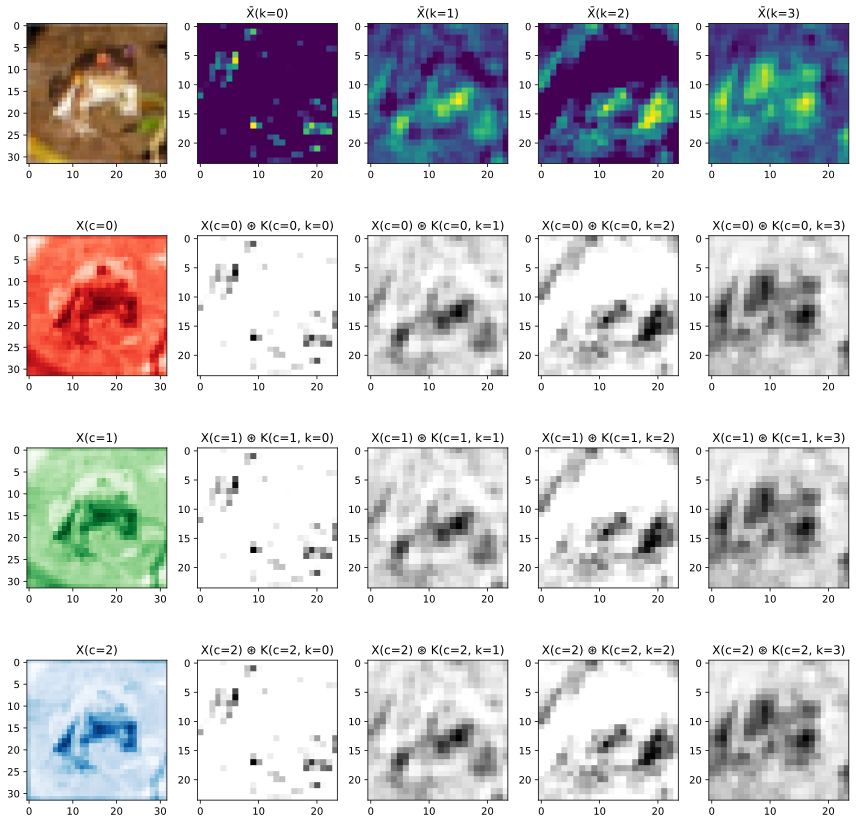

In [2]:
def conv_components(*, X, conv, act):
    """Components of a convolution of an RGB image with 4 output channels."""
    
    cmaps = ['Reds', 'Greens', 'Blues']

    # Get kernel weights
    conv.build(input_shape=X.shape)
    K, u = conv.get_weights()

    c_in  = X.shape[-1]
    c_out = K.shape[-1]

    # Iterate over in channels
    fig, ax = plt.subplots(c_in+1, c_out+1, figsize=(12, 12))
    ax[0, 0].imshow(X[:, :, :])
    for c in range(c_in):
        ax[c+1, 0].set_title(f'X(c={c})')
        ax[c+1, 0].imshow(X[:, :, c], cmap=cmaps[c])

    # Iterate over kernel filters
    outs = {}
    for k in range(c_out):
        conv_k = kr.layers.Conv2D(filters=1, kernel_size=conv.kernel_size, activation=act)
        conv_k.build(input_shape=(32, 32, 3))
        T, v = conv_k.get_weights()
        T[:, :, :, 0] = K[:, :, :, k]
        v[0] = u[k]
        conv_k.set_weights([T, v])
        for c in range(c_in):
            outs[(c, k)] = conv_k(X[None, :, :, :])[0, :, :, 0]
            ax[c+1, k+1].imshow(outs[(c, k)], cmap='Greys') 
            ax[c+1, k+1].set_title(f"X(c={c}) ⊛ K(c={c}, k={k})")

    # Sum convolutions for each input channel
    for k in range(c_out):
        ax[0, k+1].imshow(sum([outs[(c, k)] for c in range(c_in)]))
        ax[0, k+1].set_title(r"$\bar{\mathrm{X}}$" + f'(k={k})')

    fig.tight_layout()
    return outs


(X_train, y_train), _ = cifar10.load_data()
tf_conv = kr.layers.Conv2D(filters=4, kernel_size=9, activation='relu')
X = X_train[0] / 255. # Frog?
conv_components(X=X, conv=tf_conv, act='relu');

**Figure.** Here we can see that the channels of convolutional layers are analogous to units of dense layers. Each kernel in entries `i,j > 0` combines column-wise with the inputs to compute `X(c=i) ⊛ K(c=i, k=j)`. The sum of these terms form the output map `X̅(k=j)` above. This looks like matrix multiplication which dense layers implement but with convolutions between matrices instead of products between numbers. 

One can think of convolutional layers as the natural dense analog for images with local feature detectors as weights. The same local patch for each input channel linearly contributes to pushing the activation after being weighted by the kernel which acts as **feature detector**. So the more output channels a layer has, the more feature detectors it is learning. Each output channel consist of a map of activations indicating the degree of detected features where each pixel correspond to a local patch in the input.

### From scratch

In this section, we implement the above formula for convolution and check whether this is consisted with that implemented for the Keras `Conv2D` layer. Consistent with the above equation, this layer expects input images to have shape `(B, H, W, c)` for a batch input of size `B` of `H × W` images with `c` channels. This is also expected the shape of output of a convolutional layer.

Input shape:  (1, 32, 32, 3)
Output shape: (1, 24, 24, 4)
Kernel shape: (9, 9, 3, 4)
Bias shape:   (4,)
Mean absolute error = 2.8580416e-08

Output components (from scratch):


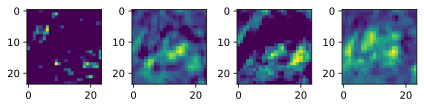

In [3]:
@np.vectorize
def np_relu(x):
    return max(0.0, x)

def scratch_conv(X, K, u, activation=None):
    """Implementing a 2D convolutional layer from scratch."""

    f = activation if activation is not None else lambda x: x

    h, w = K.shape[:2]
    B, H0, W0, c_in = X.shape
    H1 = H0 - h + 1
    W1 = W0 - w + 1
    c_out = K.shape[3]

    S = np.zeros(shape=(B, H1, W1, c_out))
    for b in range(S.shape[0]):
        for i in range(S.shape[1]):
            for j in range(S.shape[2]):
                for k in range(S.shape[3]):
                    # Perform 3D convolution (h, w, c_in) for each out channel
                    S[b, i, j, k] = f(u[k] + (K[:, :, :, k] * X[b, i:i+h, j:j+w, :]).sum())
    return S


X = X_train[0][None, :, :, :] / 255.
K = tf_conv.weights[0].numpy()
u = tf_conv.weights[1].numpy()
S = scratch_conv(X, K, u, activation=lambda x: np_relu(x))

print("Input shape: ", X.shape)   # (B, H_in,  W_in,  c_in)
print("Output shape:", S.shape)   # (B, H_out, W_out, c_out)
print("Kernel shape:", K.shape)   # (h, w, c_in, c_out)
print("Bias shape:  ", u.shape)   # (c_out,)

# Check if above formula agrees with TF implementation
print("Mean absolute error =", np.abs(S - tf_conv(X)).mean())

# Plotting the images obtained using the above formula
print("\nOutput components (from scratch):")
fig, ax = plt.subplots(1, 4)
for j in range(4):
    ax[j].imshow(S[0, :, :, j])
fig.tight_layout()

Constructing the corresponding **Toeplitz matrix** of the operation:


Output components (from Toeplitz reconstruction):


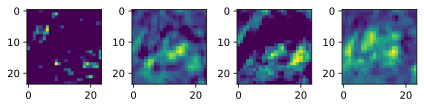

In [4]:
def output_shape(kernel, input_shape):
    h, w = kernel.shape[:2]
    B, H0, W0, c_in = input_shape
    H1, W1 = H0 - h + 1, W0 - w + 1
    c_out = kernel.shape[3]
    return B, H1, W1, c_out

def toeplitz(kernel, input_shape):
    """Constructing the Toeplitz matrix."""

    c_in = input_shape[3]
    c_out = kernel.shape[3]
    h, w  = kernel.shape[:2]
    H0, W0 = input_shape[1:3]
    B, H1, W1, c_out = output_shape(kernel, input_shape)
    
    T = np.zeros((H0 * W0, H1 * W1, c_in, c_out))
    for c in range(c_out):
        for k in range(c_in):
            for i in range(H1):
                for j in range(W1):
                    ii = i * W0 + j
                    jj = i * W1 + j
                    for hh in range(h):
                        T[ii + (hh * W0): ii + (hh * W0) + w, jj, k, c] = K[hh, :, k, c].reshape(-1)
    return T


# Constructing the output image
K = tf_conv.weights[0].numpy()
c_in = X.shape[3]
B, H1, H2, c_out = output_shape(K, X.shape)

T = toeplitz(K, X.shape)

print("\nOutput components (from Toeplitz reconstruction):")
fig, ax = plt.subplots(1, 4)
for k in range(c_out):
    s = []
    for c in range(c_in):
        x = X[0, :, :, c].reshape(-1)
        s.append(x @ T[:, :, c, k])
    s = sum(s)
    ax[k].imshow(np_relu(s).reshape(24, 24))

fig.tight_layout()

Looks good! Toeplitz matrices for the first input channel:

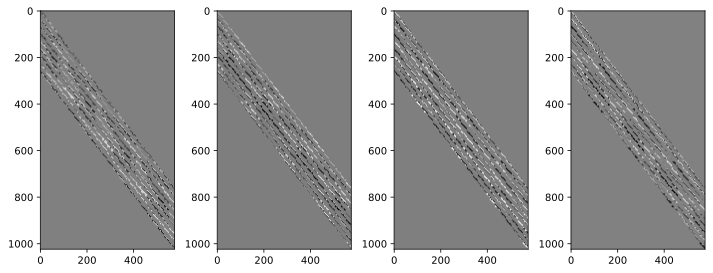

In [5]:
fig, ax = plt.subplots(1, c_out, figsize=(10, 6))
c = 0
for k in range(c_out):
    ax[k].imshow(T[:, :, c, k], cmap='gray');
plt.tight_layout()

In [6]:
s = []
for t in range(4):
    t = T[:, :, 0, 0]
    s.append((t != 0).sum() / t.size)

print(f"Average sparsity: {sum(s)/4*100:.2f}%")

Average sparsity: 7.91%


### Stride and padding

The above definition of convolution can be modified to include a parameter called the **stride** that controls the step size of the kernel when it slides over the input image. A convolution layer with stride $\mathsf{s}$ computes:

$$
\begin{aligned}
{\bar {\boldsymbol{\mathsf{X}}}}_{ij,\, k} 
&= \varphi\left({\boldsymbol{\mathsf{u}}}_{k} + \sum_{c=0}^{{\mathsf c}_\text{in}-1}\sum_{x = 0}^{{\mathsf k}_h-1} \sum_{y=0}^{{\mathsf k}_w-1} {\boldsymbol{\mathsf{X}}}_{\mathsf{s}i + x,\, \mathsf{s}j + y,\, c} \, {\boldsymbol{\mathsf{K}}}_{xyc,{k}} \right)
\end{aligned}
$$


for $k = 0, \ldots, {\mathsf c}_\text{out}-1.$ This includes the original definition which has a step size of 1. Note that strided convolutions can be thought of as a form of downsampling since it results in a significant reduction in image size. A larger stride along with a large kernel size can be useful if objects are large relative to the dimension of the image.

```{figure} ../../img/imagenet.png
---
width: 40em
name: imagenet
---
Sample images from the ImageNet dataset {cite}`imagenet`. AlexNet used a kernel of size 11×11 with a stride of 4 over images of size 224×224 in the first layer since objects in the dataset tend to occupy more pixels. 

```

Since the kernel placed entirely within the input image, this has the disadvantage of being biased towards the center pixels. This results in information loss on the edges of the input image as we stack more convolutional layers. Also, applying convolutions decreases the spatial dimension of the image which limits the depth of the network. A straightforward fix is to do **zero padding** on the edges so the kernel can be placed over the edges:

(1, 38, 38, 3)


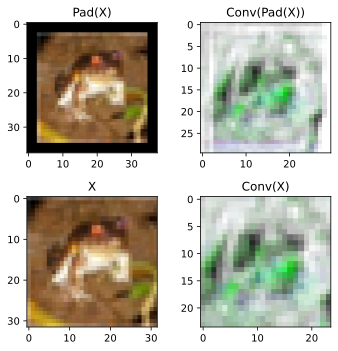

In [7]:
pad = kr.layers.ZeroPadding2D(padding=3)

print(pad(X).shape)
fig, ax = plt.subplots(2, 2, figsize=(5, 5))

ax[0, 0].imshow(pad(X)[0]);
ax[0, 1].imshow(tf_conv(pad(X))[0]);
ax[1, 0].imshow(X[0]);
ax[1, 1].imshow(tf_conv(X)[0]);

ax[0, 0].set_title("Pad(X)")
ax[0, 1].set_title("Conv(Pad(X))")
ax[1, 0].set_title("X")
ax[1, 1].set_title("Conv(X)")

fig.tight_layout()

**Output size.** An input feature map with width `w` and equal padding `p`, and kernel size `k` with stride `s` has an output with width `⌊(w + 2p - k)/s + 1⌋`. Note that we have to carefully choose stride and padding values so that the kernel can be placed evenly in the image so that no input pixel is dropped. In the case of unit stride, we have to choose the kernel size to be odd so that the kernel to cover the entire input in a symmetric manner. Choosing `p = (k-1)/2` results in the output image having the same size as the input. This setting is called **same convolution**. For non-unit stride, the best practice is to choose a kernel size and the smallest padding such that `s` divides `w + 2p - k` so the entire input image is symmetrically covered by the kernel.

### Downsampling and pooling

The **receptive field** of a unit of a hidden layer refers to all the units from all the previous layers that influences its value during forward pass. In particular, units in the final classification layer should have a receptive field that contains the whole input image in the input layer. Otherwise, some parts of the input data will not improve the performance of the model for that class. These regions can be thought of as blind spots of the model for that class.

<br>

```{margin}
**Figure 14.2** from {cite}`geron2019hands-on`
```
```{figure} ../../img/receptive_field.png
---
width: 35em
---
Receptive field of a pixel in the third layer of a convolutional network.
```

One way to increase receptive field is by **downsampling**. This is characterized by taking a sample, or aggregating samples, of pixels in the current layer so that we can pass a smaller input onto the next layer. In addition to deeper pixels being more expressive, this results in lower computational costs. Downsampling is commonly done by means of a **pooling** operation.

```{margin}
Figure from: <br>
[`cs231n/conv-nets`](https://cs231n.github.io/convolutional-networks/)
```

```{figure} ../../img/pooling-cs231n.png
---
width: 300px

---

Pooling layer downsamples the volume spatially independently in each channel. The input tensor of size 224 × 224 × 64 is pooled with filter size 2 and stride 2 into output volume of size 112 × 112 × 64.
```

Pooling layers operates like convolutional layers in that we can set a stride, padding, and kernel size. But unlike the convolution operation, pooling is non-parameteric. **Max pooling** takes 
the maximum value in the region that is covered by its kernel. This layer provides invariance to small translations of the input at the cost of some information loss which can be desirable. Note that max pooling works well with the ReLU activation since all activation values subject to comparison are all non-negative.

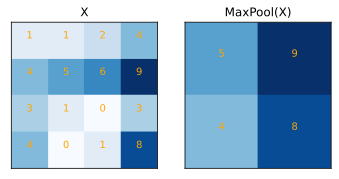

In [8]:
X = tf.convert_to_tensor([
    [ 1, 1, 2, 4],
    [ 4, 5, 6, 9],
    [ 3, 1, 0, 3],
    [ 4, 0, 1, 8]]
)[None, :, :, None]

pool = kr.layers.MaxPool2D(pool_size=2, strides=2)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(5, 2.5))
ax[0].set_title("X")
ax[0].imshow(X.numpy()[0, :, :, 0], cmap='Blues', vmin=0)
ax[0].set_xticks([])
ax[0].set_yticks([])
for i in range(4):
    for j in range(4):
        ax[0].text(j, i, X[0, i, j, 0].numpy(), ha="center", va="bottom", color='orange')

ax[1].set_title("MaxPool(X)")
ax[1].imshow(pool(X).numpy().reshape(2, 2), cmap='Blues', vmin=0)
ax[1].set_xticks([])
ax[1].set_yticks([])
for i in range(2):
    for j in range(2):
        ax[1].text(j, i, pool(X)[0, i, j, 0].numpy(), ha="center", va="bottom", color='orange')

fig.tight_layout()

Note that pooling is applied to each channel separately, so that the number of output channels is maintained. This makes sense since we want only to compress the original input without affecting its semantic structure. 

In practice, there are two commonly used settings: `k = 2` and `s = 2` where the pooling regions are do not overlap, and the more aggressive overlapping pooling with `k = 3` and `s = 2`. Using larger kernel sizes can be too aggressive resulting in loss of discriminative information. This can be observed in the example below where presence of occlusion is further emphasized by pooling.

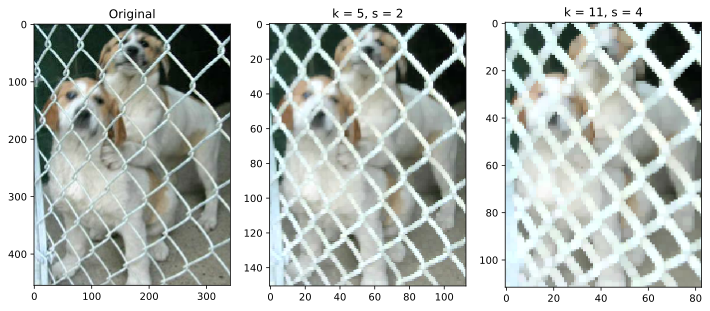

In [9]:
dog = DATASET_DIR / "cat-and-dog/test_set/test_set/dogs/dog.4008.jpg"
image_raw = tf.io.read_file(str(dog))
image = tf.image.decode_image(image_raw)[None, :, :, :]

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(image[0, :, :, :])
ax[0].set_title("Original")
ax[1].imshow(kr.layers.MaxPool2D(pool_size=5, strides=3)(image)[0, :, :, :])
ax[1].set_title("k = 5, s = 2")
ax[2].imshow(kr.layers.MaxPool2D(pool_size=11, strides=4)(image)[0, :, :, :])
ax[2].set_title("k = 11, s = 4");

## Implementing a convnet

In this section, we implement a **Convolutional Neural Network** (CNN) for classifying [FashionMNIST](https://keras.io/api/datasets/fashion_mnist/) {cite}`fashion-mnist` images using the Keras sequential API. This makes sense since a convnet is simply a stack of convolutional blocks, i.e. performing convolution, activation, and max-pooling, for feature extraction, followed by a dense classification subnetwork on the final extracted features.

Note that we will implement a network with a width of 512 in the last dense layer instead of 1024 indicated in the figure below. Significantly reducing the number of parameters of the model is nice for our small machine. To aid with activation and gradient stability, we append [Batch Normalization](https://arxiv.org/abs/1502.03167) {cite}`batchnorm` layers after each convolution and see whether this improves model performance. 

```{margin}
Figure source: <br>
[`github.com/rasbt/`](https://github.com/rasbt/machine-learning-book/blob/main/ch14/figures/14_12.png)
```
```{figure} ../../img/convnet.png
---
---
Visualizing the architecture of the network implemented below.

```

### Network architecture

Observe that the network follows the pattern of stacking `[Conv → ReLU → Pool]` blocks. This is typical in network design: using blocks composed of layers that together forms a basic functional unit. Here the spatial dimensions are downsampled while increasing the number of output channels, then the resulting long vector is passed to a dense classification subnetwork.

In [10]:
model = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=5, padding='same'),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPooling2D(pool_size=2, strides=2),
    
    kr.layers.Conv2D(filters=64, kernel_size=5, padding='same'),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPooling2D(pool_size=2, strides=2),
    
    kr.layers.Flatten(),
    kr.layers.Dense(512, activation='relu'),
    kr.layers.Dropout(rate=0.5),
    kr.layers.Dense(10, activation='softmax')
])

model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 64)        0

**Remarks.** For convolutional layers width corresponds to the number of channels of the output feature maps. This can be interpreted as the number of features that the layer learns where each feature is captured by an image. Increasing the width directly increases the capacity of the network. 

On the other hand, increasing the depth of the network correspond to higher level features that are more combinations of lower level features in the early layers of the network. Feature combination allows networks to learn patterns using less weights. This allows deep networks to learn richer representations that generalize better. The tradeoff is that these representations are generally more difficult to learn.

### Training

In [11]:
from tensorflow.keras.datasets import fashion_mnist

def preprocess(data):
    data = data.reshape((-1, 28, 28, 1))
    data = data.astype('float32') / 255.
    return data 

# Load and preprocess MNIST data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = preprocess(X_train)
X_test = preprocess(X_test)

# Split train and validation sets
X_valid = X_train[:10000]
y_valid = y_train[:10000]
X_train = X_train[10000:]
y_train = y_train[10000:]


# Compile model with Adam and cross-entropy
model.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train model on FashionMNIST data
hist = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32,
    validation_data=(X_valid, y_valid)
)

4431872/4422102 [==============================] - 1s 0us/step


2022-11-24 21:02:26.452218: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.5495 - accuracy: 0.8043 - val_loss: 0.3341 - val_accuracy: 0.8711
Epoch 2/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3659 - accuracy: 0.8665 - val_loss: 0.2735 - val_accuracy: 0.8997
Epoch 3/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3094 - accuracy: 0.8872 - val_loss: 0.2753 - val_accuracy: 0.8955
Epoch 4/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2722 - accuracy: 0.9008 - val_loss: 0.2433 - val_accuracy: 0.9079
Epoch 5/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2444 - accuracy: 0.9106 - val_loss: 0.2486 - val_accuracy: 0.9064
Epoch 6/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2223 - accuracy: 0.9183 - val_loss: 0.2248 - val_accuracy: 0.9174
Epoch 7/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2010 - accuracy: 0.9263 - val_loss: 0.2285 - val_accuracy:

Kernels learned by the model in the first layer:

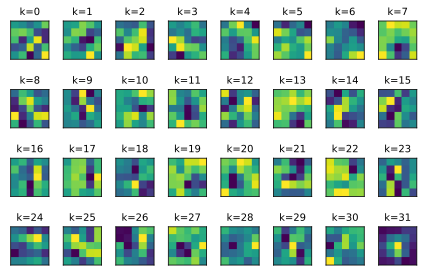

In [12]:
fig, ax = plt.subplots(4, 8)
for i in range(32):
    ax[divmod(i, 8)].set_title(f"k={i}", fontsize=10)
    ax[divmod(i, 8)].imshow(model.layers[0].weights[0][:, :, 0, i].numpy());
    ax[divmod(i, 8)].set_xticks([])
    ax[divmod(i, 8)].set_yticks([])
    
fig.tight_layout()

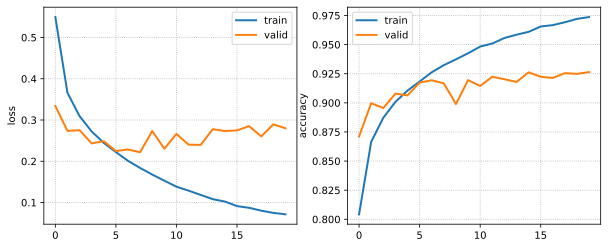

In [13]:
def plot_model_history(history, ax, metric='accuracy', label='', **kwargs):
    """Plotting result of Keras model training."""

    train_label = f'train ({label})' if len(label) > 0 else 'train'
    valid_label = f'valid ({label})' if len(label) > 0 else 'valid'
    ax[0].plot(history.history['loss'], label=train_label, color="C0", **kwargs)
    ax[0].plot(history.history['val_loss'], label=valid_label, color="C1", **kwargs)
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[0].grid(linestyle='dotted')

    ax[1].plot(history.history[metric], label=train_label, color="C0", **kwargs)
    ax[1].plot(history.history[f'val_{metric}'], label=valid_label, color="C1", **kwargs)
    ax[1].set_ylabel(metric)
    ax[1].legend()
    ax[1].grid(linestyle='dotted')


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist, ax=ax, linewidth=2)

In [14]:
print(f"Test accuracy: {model.evaluate(X_test, y_test)[1]}")

313/313 [==============================] - 1s 3ms/step - loss: 0.3203 - accuracy: 0.9210
Test accuracy: 0.9210000038146973


In [15]:
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

pred_proba = model.predict(X_test)
pred = np.argmax(pred_proba, axis=1)
pred_table = pd.DataFrame({
    'pred': pred, 
    'proba': [pred_proba[i, j] for (i, j) in enumerate(pred)], 
    'true': y_test.reshape(-1),
})

Plotting the examples where model is least confident in its prediction:

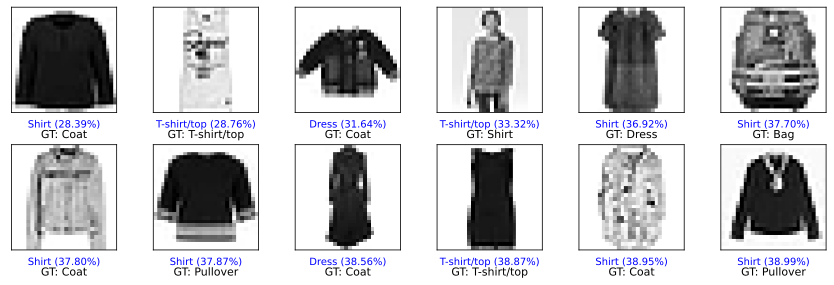

In [16]:
fig = plt.figure(figsize=(12, 4))
worst_preds = pred_table.sort_values('proba')[:12]

for i in range(12):
    img_index = worst_preds.index[i]
    image = X_test[img_index]
    row = worst_preds.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"{class_names[row['pred']]} ({row['proba']*100:.2f}%)", color='blue')
    ax.set_title(f"GT: {class_names[row['true']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

### Effect of BatchNorm

Since we already have our experiment set up, might as well run some tests. Recall that we fitted batch normalization layers after the convolutional layers. Let us see how this affects model training.

In [17]:
model_no_bn = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    kr.layers.MaxPooling2D(pool_size=2),
    
    kr.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'),
    kr.layers.MaxPooling2D(pool_size=2),
    
    kr.layers.Flatten(),
    kr.layers.Dense(512, activation='relu'),
    kr.layers.Dropout(rate=0.5),
    kr.layers.Dense(10, activation='softmax')
])


# Build and compile with Adam and cross-entropy
model_no_bn.build(input_shape=(None, 28, 28, 1))
model_no_bn.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train on FashionMNIST data
hist_no_bn = model_no_bn.fit(
    X_train, y_train, 
    epochs=20,
    batch_size=32,
    validation_data=(X_valid, y_valid)
)

Epoch 1/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4506 - accuracy: 0.8359 - val_loss: 0.2943 - val_accuracy: 0.8913
Epoch 2/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2949 - accuracy: 0.8911 - val_loss: 0.2560 - val_accuracy: 0.9078
Epoch 3/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2507 - accuracy: 0.9068 - val_loss: 0.2502 - val_accuracy: 0.9057
Epoch 4/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2176 - accuracy: 0.9188 - val_loss: 0.2354 - val_accuracy: 0.9141
Epoch 5/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1949 - accuracy: 0.9283 - val_loss: 0.2223 - val_accuracy: 0.9178
Epoch 6/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1740 - accuracy: 0.9344 - val_loss: 0.2165 - val_accuracy: 0.9212
Epoch 7/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1536 - accuracy: 0.9421 - val_loss: 0.2382 - val_accuracy:

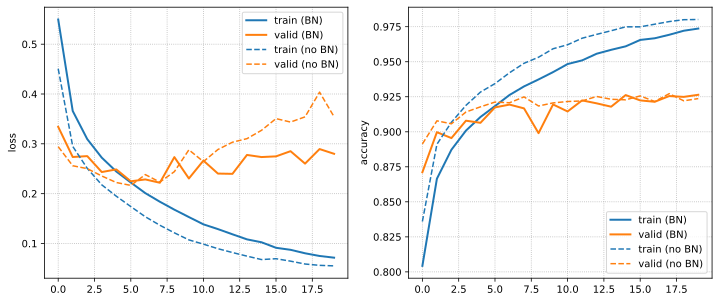

In [18]:
# Plot on same axis as prev model
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_model_history(history=hist, ax=ax, label="BN", linewidth=2)
plot_model_history(history=hist_no_bn, ax=ax, label="no BN", linestyle="dashed")

Model with batch normalization exhibits less overfitting.

In [19]:
print(f"Test accuracy (BN):     {model.evaluate(X_test, y_test, verbose=0)[1] * 100:.2f}%")
print(f"Test accuracy (w/o BN): {model_no_bn.evaluate(X_test, y_test, verbose=0)[1] * 100:.2f}%")

Test accuracy (BN):     92.10%
Test accuracy (w/o BN): 91.59%


## Data augmentation

In this section, we will create a convnet for classifying whether an image of a person is smiling or not. The dataset we will be using is [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) {cite}`celeb_a` which contains 202,599 images of celebrities’ faces. In addition, 40 binary facial attributes are available for each image, including whether the person depicted in the image is smiling or not.

To speed up training we will use only a small subset of 16,000 faces. However, this is a small dataset for image classification. To train a network that generalizes, we will use **data augmentation**. This technique incorporates transformed versions of the original images into the dataset resulting in a model that is robust to label preserving transformations such as rotation and translation. Plotting example images with their labels:

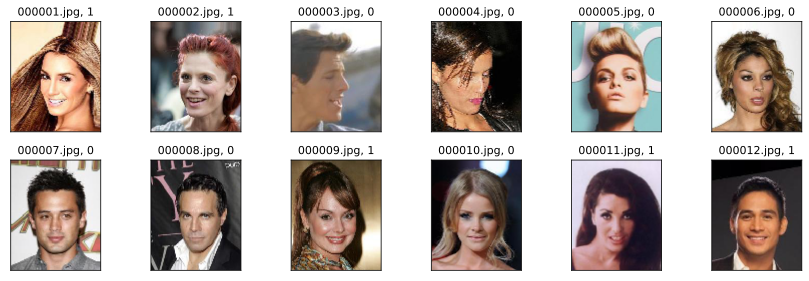

In [20]:
image_dir_path = DATASET_DIR / "celeba-dataset" / "img_align_celeba" / "img_align_celeba"
face_file_list = sorted([str(path) for path in image_dir_path.glob("*.jpg")])

# Get id -> target dictionary
dataset_path = DATASET_DIR / 'celeba-dataset'
attr = pd.read_csv(dataset_path / 'list_attr_celeba.csv')[['image_id', 'Smiling']]
attr['Smiling'] = attr['Smiling'].map({1: 1, -1: 0})
get_smile = dict(zip(attr.image_id, attr.Smiling))

# Plot examples from dataset
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    image_path = face_file_list[i]
    image_id = image_path.split('/')[-1]
    label = get_smile[image_id]
    image = plt.imread(image_path)

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.imshow(image)
    ax.set_title(f"{image_id}, {label}", fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

### Transformations

TensorFlow provides transformations for images in the [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image) library.

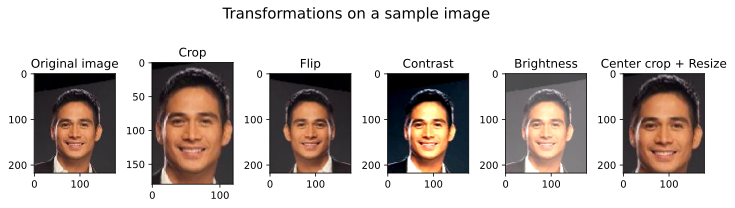

In [21]:
# Get sample image
image = plt.imread(face_file_list[11])

# Apply augmentations to sample image
cropped                 = tf.image.crop_to_bounding_box(image, 25, 30, 180, 120)
flipped                 = tf.image.flip_left_right(image)
contrast_adjusted       = tf.image.adjust_contrast(image, 2.)
brightness_adjusted     = tf.image.adjust_brightness(image, delta=0.3)
center_cropped          = tf.image.central_crop(image, central_fraction=0.7)
resized_center_cropped  = tf.image.resize(center_cropped, size=[218, 178]) / 255.

# Visualize
fig, ax = plt.subplots(1, 6, figsize=(10, 3))

ax[0].set_title("Original image")
ax[1].set_title("Crop")
ax[2].set_title("Flip")
ax[3].set_title("Contrast")
ax[4].set_title("Brightness")
ax[5].set_title("Center crop + Resize")

ax[0].imshow(image)
ax[1].imshow(cropped)
ax[2].imshow(flipped)
ax[3].imshow(contrast_adjusted)
ax[4].imshow(brightness_adjusted)
ax[5].imshow(resized_center_cropped)

fig.suptitle("Transformations on a sample image", fontsize=15)
fig.tight_layout()

To perform data augmentation, we randomly sample the transformation parameters from some distribution. This allows us to perturb the data points without changing the labels. Note that care must be taken to ensure that the transformations do not modify the labels or make it ambiguous. The last column consisting of `64x64` images will make up the training data.

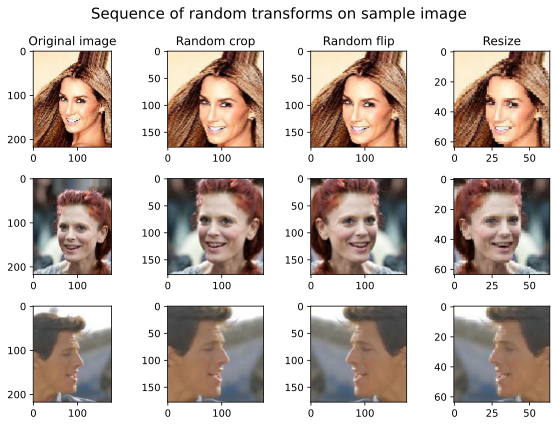

In [22]:
fig, ax = plt.subplots(3, 4, figsize=(8, 6))

ax[0, 0].set_title("Original image")
ax[0, 1].set_title("Random crop")
ax[0, 2].set_title("Random flip")
ax[0, 3].set_title("Resize")

for i, file_name in enumerate(face_file_list[:3]):
    image = plt.imread(file_name)
    ax[i, 0].imshow(image)
    image = tf.image.random_crop(image, size=(178, 178, 3))
    ax[i, 1].imshow(image)
    image = tf.image.random_flip_left_right(image)
    ax[i, 2].imshow(image)
    image = tf.image.resize(image, size=[64, 64]) / 255.
    ax[i, 3].imshow(image)
    
fig.suptitle("Sequence of random transforms on sample image", fontsize=15)
fig.tight_layout()

### Augmented datasets

Note that for our training dataset, we apply a sequence of random transformations. For test data, we remove the stochasticity to avoid unnecessary information loss. This can also be interpreted as applying the "expected" transformation at inference. Particular care must be taken with cropping, otherwise we may crop the mouth region out which is highly predictive of a smile.

In [23]:
@tf.function
def transform(image, size=(64, 64), augment=True):
    """Full image transformation pipeline."""
    
    if augment:
        image = tf.image.random_crop(image, size=(178, 178, 3))
        image = tf.image.random_flip_left_right(image)
    else:
        image = tf.image.crop_to_bounding_box(
            image, offset_height=20, offset_width=0, 
            target_height=178, target_width=178
        ) # (218 - 178)/2 = 20, (178 - 178)/2 = 0

    image = tf.image.resize(image, size=size) / 255.
    return image
    

def load_jpeg(file_path):
    image_raw = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    return image


def image_id(file_path):
    return file_path.split('/')[-1] 


def create_image_dataset(file_list):
    labels = [get_smile[image_id(file_path)] for file_path in file_list]
    paths_ds = tf.data.Dataset.from_tensor_slices((file_list, labels))
    image_ds = paths_ds.map(lambda file_path, label: (load_jpeg(file_path), label))
    return image_ds


# Create train, valid, and test data loaders outside of train loop.
random.shuffle(face_file_list)
train_ds = create_image_dataset(face_file_list[:16000])
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.map(lambda x, y: (transform(x), y))

valid_ds = create_image_dataset(face_file_list[16000:17000])
valid_ds = valid_ds.map(lambda x, y: (transform(x, augment=False), y))

test_ds = create_image_dataset(face_file_list[17000:18000])
test_ds = test_ds.map(lambda x, y: (transform(x, augment=False), y))

Checking if the labels are balanced:

In [24]:
print(r"Fraction smile:")
name = ['train', 'valid', 'test']
for i, ds in enumerate([train_ds, valid_ds, test_ds]):
    X, y = list(ds.batch(16000).as_numpy_iterator())[0]
    print(f"  {name[i]:5s}   {y.mean()*100:.1f}%")

Fraction smile:
  train   48.8%
  valid   45.8%
  test    46.2%


The mapping is applied lazily each time the dataset is iterated over. This is nice since we want a different randomization for each epoch. Note that the ordering between `shuffle` and `map` is important. This is done so that `shuffle` maintains state across iterations and we get different augmentations for each epoch. Batch size for the data loaders will have to be set up later. The following code which simulates three sample images across multiple epochs can be useful for debugging this:

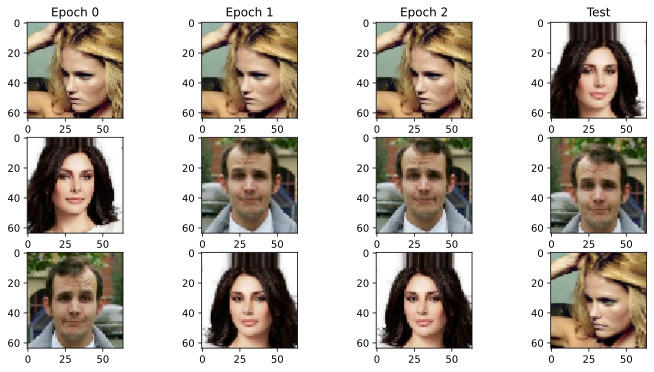

In [25]:
# In this demo, we likewise create loaders outside of train loops
train_demo = create_image_dataset(face_file_list[:3])
train_demo = train_demo.shuffle(1000)                           # order important! 
train_demo = train_demo.map(lambda x, y: (transform(x), y))     # shuffle -> map
train_demo = train_demo.batch(1)

fig, ax = plt.subplots(3, 4, figsize=(12, 6))

# Training
for epoch in range(3):
    ax[0, epoch].set_title(f"Epoch {epoch}")
    for b, batch in enumerate(train_demo):
        ax[b, epoch].imshow(batch[0][0, :, :, :])

# Inference: use same images for comparison
test_demo = create_image_dataset(face_file_list[:3])
test_demo = test_demo.map(lambda x, y: (transform(x, augment=False), y))
test_demo = test_demo.batch(1)

ax[0, 3].set_title(f"Test")
for b, batch in enumerate(test_demo):
    ax[b, 3].imshow(batch[0][0, :, :, :])

### Model = Conv + GAP

Now that we have our data loaders, let us look at the model architecture that we will use for smile classification. The input data goes through four convolutional layers to make 32, 64, 128, and 256 feature maps using `3×3` same convolutions, `2×2` nonoverlapping max-pooling blocks. Batch normalization layers are also included for regularization.

In [26]:
model = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=3, padding="same"),
    kr.layers.ReLU(),
    kr.layers.MaxPool2D(strides=2, pool_size=2),
    kr.layers.Dropout(0.3),

    kr.layers.Conv2D(filters=64, kernel_size=3, padding="same"),
    kr.layers.ReLU(),
    kr.layers.MaxPool2D(strides=2, pool_size=2),
    kr.layers.Dropout(0.3),
    
    kr.layers.Conv2D(filters=128, kernel_size=3, padding="same"),
    kr.layers.ReLU(),
    kr.layers.MaxPool2D(strides=2, pool_size=2),
    
    kr.layers.Conv2D(filters=256, kernel_size=3, padding="same"),
    kr.layers.ReLU(),
    kr.layers.GlobalAveragePooling2D(),
    
    kr.layers.Flatten(),
    kr.layers.Dense(units=2, activation="softmax")
])

model.build(input_shape=(None, 64, 64, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
re_lu_3 (ReLU)               (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)       

At the final convolutional layer, we have 256 many 8 × 8 feature maps. Flattening this into a 256 × 8 × 8 = 16,384 long vector results in the loss of learned semantic structure. Not to mention the excess in capacity of the dense layer that takes this vector as input.

An alternative that we use here is a **global average-pooling** (GAP) layer which averages all pixels in the 8 × 8 feature map into a single pixel. Averaging over the spatial dimensions can make the model more robust to small spatial translations in the input. But more importantly, compressing the spatial dimension allows us to preserve the channel structure, while reducing the output to a vector of length 256. This vector can then be passed to a dense layer to perform classification.

### Training and results

Training the model with Adam with a learning rate of $10^{-3}$ and a batch size of 32.

In [27]:
model.compile(
    loss=kr.losses.SparseCategoricalCrossentropy(),
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

callback = kr.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=5,
    restore_best_weights=True,
)

# Fit model with data augmentation
batch_size = 32
train_loader = train_ds.batch(batch_size, drop_remainder=True)
valid_loader = valid_ds.batch(batch_size)
test_loader  =  test_ds.batch(batch_size)

hist = model.fit(
    train_loader,
    epochs=50,
    validation_data=valid_loader,
    callbacks=[callback],
)

Epoch 1/50
500/500 [==============================] - 12s 22ms/step - loss: 0.6936 - accuracy: 0.5105 - val_loss: 0.6896 - val_accuracy: 0.5420
Epoch 2/50
500/500 [==============================] - 12s 23ms/step - loss: 0.6921 - accuracy: 0.5136 - val_loss: 0.6869 - val_accuracy: 0.5570
Epoch 3/50
500/500 [==============================] - 11s 21ms/step - loss: 0.6888 - accuracy: 0.5303 - val_loss: 0.6759 - val_accuracy: 0.5780
Epoch 4/50
500/500 [==============================] - 12s 23ms/step - loss: 0.6840 - accuracy: 0.5486 - val_loss: 0.6614 - val_accuracy: 0.5830
Epoch 5/50
500/500 [==============================] - 11s 22ms/step - loss: 0.6786 - accuracy: 0.5636 - val_loss: 0.6569 - val_accuracy: 0.6030
Epoch 6/50
500/500 [==============================] - 12s 23ms/step - loss: 0.6669 - accuracy: 0.5917 - val_loss: 0.6811 - val_accuracy: 0.5750
Epoch 7/50
500/500 [==============================] - 11s 21ms/step - loss: 0.6393 - accuracy: 0.6349 - val_loss: 0.6075 - val_accuracy:

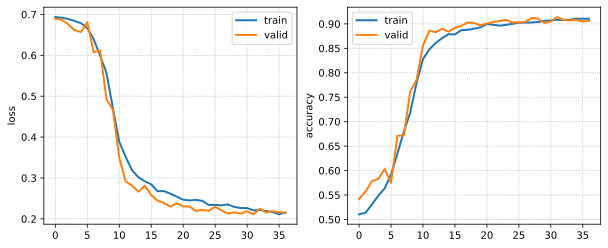

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist, ax=ax, linewidth=2)

**Remark.** Turning off data augmentation results in extreme divergence where the model overfits early on in the training. Adding random transformations on the train set makes it harder for the model to memorize aspects of smile that only exist in how the training data is presented, e.g. looking at smiles in the lower center of images. At the same time, the model learns to pick up representations that are invariant to these random perturbations in the inputs.

In [29]:
print(f"train acc: {model.evaluate(train_loader, verbose=0)[1] * 100:.2f}%") # stochastic
print(f"valid acc: {model.evaluate(valid_loader, verbose=0)[1] * 100:.2f}%")
print(f"test  acc: {model.evaluate( test_loader, verbose=0)[1] * 100:.2f}%")

train acc: 92.30%
valid acc: 91.40%
test  acc: 90.90%


In [30]:
X_test, y_test = next(iter(test_ds.batch(1000)))
pred_proba = model.predict(X_test)[:, 1]
pred_table = pd.DataFrame({'pred': pred_proba, 'truth': y_test})
pred_table['confidence'] = np.abs(pred_table['pred'] - 0.5) / 0.5
pred_table['correct'] = (pred_table['pred'] > 0.5) == pred_table['truth']
pred_table.head(5)

,pred,truth,confidence,correct
0,0.027976,0,0.944048,True
1,0.998319,1,0.996639,True
2,0.136590,1,0.726819,False
3,0.999794,1,0.999587,True
4,0.031436,0,0.937129,True


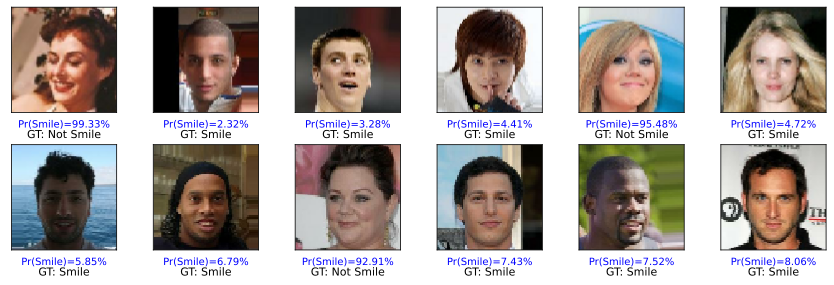

In [31]:
class_names = {
    0: 'Not Smile',
    1: 'Smile'
}

confused = (pred_table
    .sort_values('confidence', ascending=False)
    .query('correct == False')
)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    img_index = confused.index[i]
    image = X_test[img_index]
    row = confused.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"Pr(Smile)={row['pred']*100:.2f}%", color='blue')
    ax.set_title(f"GT: {class_names[row['truth']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

**Figure.** Test examples where model is confidently wrong. Here we have to look out for incorrect labels. Otherwise, these are examples where the model has the highest loss. This may be fixed by preprocessing or perhaps adding further augmentation (e.g. adjust brightness). Images with ambiguous labels should have low prediction confidence. See next figure.

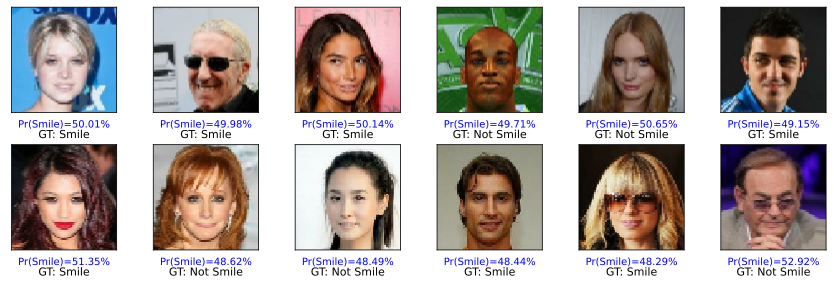

In [32]:
unsure = pred_table.sort_values('confidence', ascending=True)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    image_index = unsure.index[i]
    image = X_test[image_index]
    row = unsure.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"Pr(Smile)={row['pred']*100:.2f}%", color='blue')
    ax.set_title(f"GT: {class_names[row['truth']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

**Figure.** Test examples where model have low confidence. Indeed, for some of these faces have ambiguous smiles. But otherwise, we can see that the model is having trouble with smiles that do not show teeth.

## Class activation maps

Previously, we introduced the concept of **class activation maps** (CAMs) {cite}`cams` in the context of GAP layers. We will try to construct this for the current model. Recall a CAM highlights the class-specific discriminative regions of an input image. So a GAP-CNN network does not only tell us what objects are present in the image, it also tells us where these objects are in the image and with no further training!

Looking at the model summary, note that the GAP layer output has 258 units. To construct the class activation maps, for each input $\boldsymbol{\mathsf x}$ we take the activations of the final ReLU layer which has shape (8, 8, 256) as **activation maps** $f_i(\boldsymbol{\mathsf x})$ of shape (8, 8) for $i = 1, \ldots, 256$ with nonnegative pixel values. Then, we take the weights ${\mathsf w}_{ij}$ of the dense layer which maps the output of the GAP layer to binary classes with label $j$ (smile or not smile), and compute the sum

$$\textsf{CAM}(\boldsymbol{\mathsf x}, j) = \sum_{i=1}^{256} f_i(\boldsymbol{\mathsf x})\,{\mathsf w}_{ij}.$$

The resulting image is (8, 8) which we can resize for better resolution. Then we overlay this on the input image $\boldsymbol{\mathsf x}$ resized to the same height and width. Thus, what we've done here is expand the linear combination of zero-dimensional average activation values to a linear combination of 2-dimensional activation maps. CAMs are implemented in the following code block for test examples.

Note that class scores are obtained by a linear combination of the average pixel values in each activation map. Since spatial ordering is preserved by convolutional layers, then the activations should indicate which pixels in the input that is in its receptive field triggered the activation, i.e. whose local representation matched the pattern in the kernel. Moreover, since the activation maps have positive pixel values, we can use the weights in the linear combination as a measure of importance for each activation for a given class.

<br>

```{figure} ../../img/cams.png
---
width: 50em
---
GAP layer flattens the final feature map by collapsing its spatial dimensions. Using nonnegative activation such as ReLU in the final block is essential so that the learned weight in the dense layer can be used to construct the CAMs that highlight class-specific discriminative regions. For the Australian terrier class above, it appears that $\mathsf{w}_1 = 0.$ {cite}`cams`
```

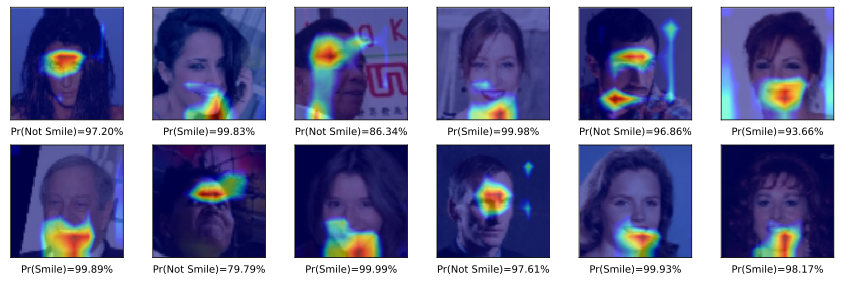

In [33]:
from functools import reduce

def calculate_cam(x, t, height, width):
    """CAM of one instance taken with respect to the predicted label.
    Note that this function has no access to the ground truth label."""
    
    class_weight = model.layers[-1].get_weights()[0] # (256, m) where m = 2 (# classes)
    resize = kr.layers.Resizing(height, width)

    # Apply layers up to final conv. activation. (1, 8, 8, 256) -> (1, 64, 256)
    act_map = tf.reshape(reduce(lambda x, f: f(x), model.layers[:-4], x), (-1, 64, 256))
    weights = class_weight[:, [t]]
    cam = act_map @ weights
    cam = resize(tf.reshape(cam, (8, 8, 1))).numpy()
    
    return cam


def plot_cam(X, height=96, width=96):
    """Plot class activation maps (CAM) for each image in batch.
    The CAM will be taken with respect to the predicted label."""

    class_label = {0: 'Not Smile', 1: 'Smile'}
    resize = kr.layers.Resizing(height, width)

    fig, ax = plt.subplots(2, 6, figsize=(12, 4))
    for b in range(12):
        x = X[b, :, :, :][None, :, :, :]
        t = tf.argmax(model(x), axis=1).numpy()[0]
        cam = calculate_cam(x, t, height, width)
        u = cam.min()
        v = cam.max()
        cam = (cam - u) / (v - u)
        cam = np.clip(cam, 0.5, 1.0)
        
        ax[divmod(b, 6)].imshow(resize(x)[0])
        ax[divmod(b, 6)].imshow(cam, alpha=0.75, cmap='jet', interpolation='sinc')
        ax[divmod(b, 6)].set_xlabel(f"Pr({class_label[t]})={model(x)[0, t]*100:.2f}%", color='black')
        ax[divmod(b, 6)].set_xticks([])
        ax[divmod(b, 6)].set_yticks([])

    fig.tight_layout()


X, _ = next(iter(test_ds.batch(12)))
plot_cam(X) # Detect smile

**Figure.** CAMs of test images for the predicted class. Note that the model has no access to ground truth. Regions colored red indicate high activation values towards that class. These are regions that contain highly discriminative features for the model. The model focuses on mouth region to predict the positive class which should be natural.

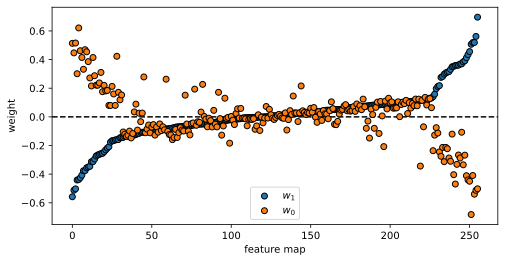

In [34]:
W = model.layers[-1].weights[0].numpy()

w0 = W[:, 0]
w1 = W[:, 1]
q = np.argsort(w1)

plt.figure(figsize=(8, 4))
plt.axhline(0, color='black', linestyle='dashed', zorder=-3)
plt.scatter(range(256), w1[q], edgecolor='black', label="$w_1$")
plt.scatter(range(256), w0[q], edgecolor='black', label="$w_0$")
plt.ylabel("weight")
plt.xlabel("feature map")
plt.legend();

**Figure.** Dense layer weights corresponding to each feature map. Notice that the weights for the negative and positive classes are in the opposite directions for each feature map. This indicates that the convolutional layer before the GAP layer has learned kernels that detect regions containing discriminative features.

## Transfer learning

**Transfer learning** consists of taking weights, and hence feature representations, learned on one problem, and leveraging them on a new, similar problem. In the following experiment, we will use a [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) {cite}`mobilenet` model pretrained on ImageNet. This has around 2.3 million parameters and was designed to have fast inference times for resource constrained environments. This section follows the Keras guide [*Transfer learning & fine-tuning*](https://keras.io/guides/transfer_learning/). 


```{margin}
**Figure 8.12** in {cite}`keras2`
``` 
```{figure} ../../img/transfer-learning.png
---
width: 40em
---
Replacing with a new classifiers while keeping the same convolutional base.
```

Observe that the convolutional networks we encountered consist of two subnetworks: a convolutional base, that acts as a feature extractor, and a classifier on top of the base network that processes the extracted features to get class probabilities. The idea behind transfer learning is that we can take the convolutional base, that is extensively trained on a large dataset, and use its learned representations to train a new classifier on a similar task. This leads us to the following workflow:

 1. Instantiate a base model and load pre-trained weights into it.
 2. Freeze all layers in the base model by setting its `trainable` attribute to `False`.
 4. Add new layers on top of the base model.
 5. Train your new model on your new dataset.

An alternative workflow is to pass the input data *once* to the base model to get feature vectors. These vectors are then used to train a new, smaller model. This is cheaper, but we cannot use it along with data augmentation which transforms input data at each training iteration.

In [35]:
base_model = kr.applications.MobileNetV2(
    weights='imagenet',         # Load weights pre-trained on ImageNet.
    input_shape=(96, 96, 3),    # We will have to resize for our 64x64x3 train dataset.
    include_top=False           # Do not include the ImageNet classifier at the top.
)

# Freeze the weights
base_model.trainable = False

# Stack a classification subnetwork on top of base model
inputs = kr.Input(shape=(64, 64, 3))
x = kr.layers.Resizing(96, 96)(inputs)
x = base_model(x, training=False)            # Inference mode! ⚠⚠⚠
x = kr.layers.GlobalAveragePooling2D()(x)    # 3x3x1280 -> 1x1x1280. Remove for performance. 
x = kr.layers.Flatten()(x)
x = kr.layers.Dense(256, activation='relu')(x)
x = kr.layers.Dropout(0.5)(x)
outputs = kr.layers.Dense(1)(x)

model = kr.Model(inputs, outputs)
model.summary()

9420800/9406464 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
resizing_13 (Resizing)       (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               327936    
________________________________________________________________

**Remark.** Instantiating the base model in inference mode is important as discussed in the following section.

In [36]:
model.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss=kr.losses.BinaryCrossentropy(from_logits=True),
    metrics=[kr.metrics.BinaryAccuracy()]
)

# Fit model with data augmentation
hist_transfer = model.fit(
    train_loader,
    epochs=20,
    validation_data=valid_loader
)

Epoch 1/20
500/500 [==============================] - 16s 26ms/step - loss: 0.5868 - binary_accuracy: 0.6794 - val_loss: 0.5373 - val_binary_accuracy: 0.7190
Epoch 2/20
500/500 [==============================] - 13s 25ms/step - loss: 0.5315 - binary_accuracy: 0.7239 - val_loss: 0.5284 - val_binary_accuracy: 0.7200
Epoch 3/20
500/500 [==============================] - 13s 25ms/step - loss: 0.5178 - binary_accuracy: 0.7253 - val_loss: 0.5259 - val_binary_accuracy: 0.7340
Epoch 4/20
500/500 [==============================] - 13s 24ms/step - loss: 0.5098 - binary_accuracy: 0.7293 - val_loss: 0.5340 - val_binary_accuracy: 0.7410
Epoch 5/20
500/500 [==============================] - 14s 26ms/step - loss: 0.5020 - binary_accuracy: 0.7393 - val_loss: 0.5213 - val_binary_accuracy: 0.7370
Epoch 6/20
500/500 [==============================] - 12s 24ms/step - loss: 0.4959 - binary_accuracy: 0.7414 - val_loss: 0.5176 - val_binary_accuracy: 0.7270
Epoch 7/20
500/500 [==============================] 

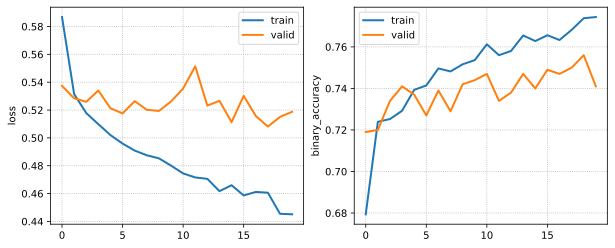

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist_transfer, ax=ax, metric='binary_accuracy', linewidth=2)

In [38]:
print(f"Train accuracy: {model.evaluate(train_loader, verbose=0)[1] * 100:.2f}%")
print(f"Valid accuracy: {model.evaluate(valid_loader, verbose=0)[1] * 100:.2f}%")
print(f"Test accuracy:  {model.evaluate( test_loader, verbose=0)[1] * 100:.2f}%")

Train accuracy: 78.87%
Valid accuracy: 74.10%
Test accuracy:  75.00%


### Fine-tuning

A last optional step is **fine-tuning** which consists of unfreezing the pre-trained model, or part of it, on the new task with very low learning rate. This can potentially achieve meaningful improvements. But could also potentially lead to quick overfitting due to the potentially large number of parameters in the base model which is why we use a small learning rate. 

Note that it is critical to fine-tune a model only after the model with frozen layers has been trained to convergence. Mixing pretrained layers with randomly initialized layers will destroy the pretrained weights due to large gradient updates during the early stages of training.

In [39]:
# Unfreeze the base model.
base_model.trainable = True

# Recompile to take unfreezing into account.
model.compile(
    optimizer=kr.optimizers.Adam(1e-5),  # Very low learning rate
    loss=kr.losses.BinaryCrossentropy(from_logits=True),
    metrics=[kr.metrics.BinaryAccuracy()]
)

# Stop before it overfits!
callback = kr.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

# Batch normalization still runs in inference mode. (See appendix.)
epochs = 10
hist_finetune = model.fit(
    train_loader,
    epochs=epochs, 
    validation_data=valid_loader,
    callbacks=[callback]
)

Epoch 1/10
500/500 [==============================] - 30s 51ms/step - loss: 0.4072 - binary_accuracy: 0.7991 - val_loss: 0.4273 - val_binary_accuracy: 0.8300
Epoch 2/10
500/500 [==============================] - 26s 52ms/step - loss: 0.3408 - binary_accuracy: 0.8396 - val_loss: 0.3649 - val_binary_accuracy: 0.8410
Epoch 3/10
500/500 [==============================] - 26s 51ms/step - loss: 0.3020 - binary_accuracy: 0.8601 - val_loss: 0.3530 - val_binary_accuracy: 0.8570
Epoch 4/10
500/500 [==============================] - 26s 51ms/step - loss: 0.2715 - binary_accuracy: 0.8717 - val_loss: 0.3574 - val_binary_accuracy: 0.8620
Epoch 5/10
500/500 [==============================] - 27s 53ms/step - loss: 0.2519 - binary_accuracy: 0.8843 - val_loss: 0.3360 - val_binary_accuracy: 0.8440
Epoch 6/10
500/500 [==============================] - 27s 53ms/step - loss: 0.2355 - binary_accuracy: 0.8899 - val_loss: 0.3146 - val_binary_accuracy: 0.8760
Epoch 7/10
500/500 [==============================] 

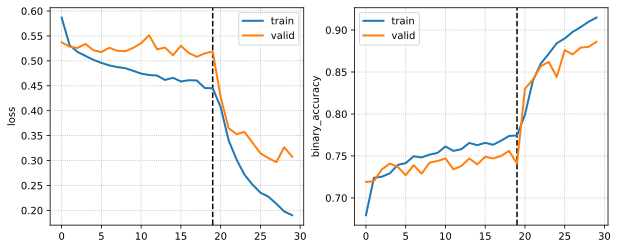

In [40]:
for key in hist_transfer.history.keys():
    hist_finetune.history[key] = hist_transfer.history[key] + hist_finetune.history[key]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].axvline(len(hist_transfer.history["loss"]) - 1, color="black", linestyle="dashed")
ax[1].axvline(len(hist_transfer.history["loss"]) - 1, color="black", linestyle="dashed")
plot_model_history(history=hist_finetune, ax=ax, metric="binary_accuracy", linewidth=2)

Fine-tuning drastically improves model performance, but as expected the model quickly overfits after a few epochs due to overcapacity. Although we were not able to obtain a better scores below with fine-tuning compared to our previous smile classification convnet, we expect better results using more powerful hardware.

In [41]:
print(f"train acc: {model.evaluate(train_loader, verbose=0)[1] * 100:.2f}%")
print(f"valid acc: {model.evaluate(valid_loader, verbose=0)[1] * 100:.2f}%")
print(f"test  acc: {model.evaluate( test_loader, verbose=0)[1] * 100:.2f}%")

train acc: 92.76%
valid acc: 88.60%
test  acc: 90.10%


### Appendix: BatchNorm

Freezing weights (`trainable=False`) make batchnorm layers run in inference mode (`training=False`). This is not overridden by running the wrapping model in training mode. This means that batchnorm statistics will not update during transfer learning. While `trainable` and `training` are orthogonal concepts in principle, this default behavior makes sense since the trainable parameters in the batchnorm layers of the base model are fixed. To check this we define a function that prints the sum of batchnorm statistics before and after a call in training mode.

In [42]:
def simulate_train(model, bn_index, batch_size=512):
    """Print sum of BN weights before and after a train step."""
    
    bn_layer = model.layers[bn_index]
    before_γ = bn_layer.weights[0].numpy()[0]
    before_μ = bn_layer.weights[2].numpy()[0]

    # train step: (1) pass input at train time + (2) update weights 
    with tf.GradientTape() as tape:
        z = model(tf.random.normal([batch_size,]), training=True)

    grads = tape.gradient(z, model.trainable_weights)
    for w, g in zip(model.trainable_variables, grads):
        dw = 10.0 * g
        w.assign_add(-dw)

    after_γ  = bn_layer.weights[0].numpy()[0]
    after_μ  = bn_layer.weights[2].numpy()[0]

    print(f"(γ):  {before_γ} -> {after_γ}")
    print(f"(μ):  {before_μ} -> {after_μ}")

Recall that the standard recipe for transfer learning is to instantiate `base_model` in **inference** mode. Results below also show that this will not be overridden by running the wrapper model in train mode after being initialized in inference mode, so that the layers of the base model will continue to run in inference mode even when we unfreeze the weights during fine-tuning:

In [43]:
# (1a) Freezing weights => BN inference mode.
base_model = kr.layers.BatchNormalization()
base_model.trainable = False

# (1b) Initializing base model in inference mode
x = kr.Input(shape=(1,))
h = base_model(x, training=False)
y = tf.reduce_sum(tf.math.tanh(h) ** 2)
model = kr.Model(x, y)

print("Simulating transfer learning")
simulate_train(model, 1)

# (2) Unfreezing base model weights for fine-tuning
base_model.trainable = True
print("\nSimulating fine-tuning")
simulate_train(model, 1)

Simulating transfer learning
(γ):  1.0 -> 1.0
(μ):  0.0 -> 0.0

Simulating fine-tuning
(γ):  1.0 -> -1898.662109375
(μ):  0.0 -> 0.0


This prevents updates on non-trainable weights which are not scaled by the learning rate and may suddenly destroy what the model has learned during transfer learning. Consider this as training with zero batchnorm momentum. Initializing the model **not** in inference mode results in updates of the moving mean when we unfreeze weights and train for fine-tuning:

In [44]:
# (1a) Freezing weights => BN inference mode.
base_model = kr.layers.BatchNormalization()
base_model.trainable = False

# (1b) Initializing base model NOT in inference mode
x = kr.Input(shape=(1,))
h = base_model(x)                          # <- (!!)
y = tf.reduce_sum(tf.math.tanh(h) ** 2)
model = kr.Model(x, y)

print("Simulating transfer learning")
simulate_train(model, 1)

# (2) Unfreezing base model weights for fine-tuning
base_model.trainable = True
print("\nSimulating fine-tuning")
simulate_train(model, 1)

Simulating transfer learning
(γ):  1.0 -> 1.0
(μ):  0.0 -> 0.0

Simulating fine-tuning
(γ):  1.0 -> -1857.31396484375
(μ):  0.0 -> 0.00013156599015928805
